# Welcome to the Dask-DataFrame Notebook!

## Purpose of this notebook
This notebook aims to cover dataframes in Dask in general. If you are already familiar with the concept you may want to skip straight to the next notebook.

## Contents of this notebook
The contents of this notebook are taken from https://examples.dask.org/dataframe.html. The only change is in the client initialization steps for connecting to the cluster.


## What is a Dask DataFrame?

Dask Dataframes coordinate many Pandas dataframes, partitioned along an index. They support a large subset of the Pandas API.

## Connecting to the cluster

Note that this section is different in Domino than in typical tutorial code (see the first Calculate Pi notebook for details). You may want to go back to the Workspaces page and click "Open" again for this same workspace, in order to have two browser tabs side-by-side for seeing the Dask Web UI at the same time as you are running this notebook.

In [1]:
from dask.distributed import Client
import os

service_host = os.environ["DASK_SCHEDULER_SERVICE_HOST"]
service_port = os.environ["DASK_SCHEDULER_SERVICE_PORT"]
client = Client(address=f"{service_host}:{service_port}")

# you should now be connected to the cluster
# Dashboard link from the client object is clickable but will not route in Domino
# Use the embedded Dask Web UI tab instead

# You can also expand the "Scheduler Info" in the client object to see some cluster information
client

<Client: 'tcp://10.0.44.9:8786' processes=3 threads=3, memory=12.00 GiB>

## Create Random Dataframe

We create a random timeseries of data with the following attributes:

1.  It stores a record for every 10 seconds of the year 2000
2.  It splits that year by month, keeping every month as a separate Pandas dataframe
3.  Along with a datetime index it has columns for names, ids, and numeric values

This is a small dataset of about 240 MB. Increase the number of days or reduce the frequency to practice with a larger dataset.

In [2]:
import dask
import dask.dataframe as dd
df = dask.datasets.timeseries()

Unlike Pandas, Dask DataFrames are lazy and so no data is printed here.

In [3]:
df

,id,name,x,y
npartitions=30,,,,
2000-01-01,int64,object,float64,float64
2000-01-02,...,...,...,...
...,...,...,...,...
2000-01-30,...,...,...,...
2000-01-31,...,...,...,...


In [4]:
df.dtypes

id        int64
name     object
x       float64
y       float64
dtype: object

Some operations will automatically display the data.

In [5]:
import pandas as pd
pd.options.display.precision = 2
pd.options.display.max_rows = 10

In [6]:
df.head(3)

,id,name,x,y
timestamp,,,,
2000-01-01 00:00:00,976,Oliver,0.39,0.82
2000-01-01 00:00:01,1034,Zelda,-0.30,-0.13
2000-01-01 00:00:02,996,Dan,-0.35,0.95


## Use Standard Pandas Operations

Most common Pandas operations operate identically on Dask dataframes

In [7]:
df2 = df[df.y > 0]
df3 = df2.groupby('name').x.std()
df3

Dask Series Structure:
npartitions=1
    float64
        ...
Name: x, dtype: float64
Dask Name: sqrt, 157 tasks

Call `.compute()` when you want your result as a Pandas dataframe.

If you started `Client()` above then you may want to watch the status page during computation.

In [8]:
computed_df = df3.compute()
type(computed_df)

pandas.core.series.Series

In [9]:
computed_df

name
Alice      0.58
Bob        0.58
Charlie    0.58
Dan        0.58
Edith      0.58
           ... 
Victor     0.58
Wendy      0.58
Xavier     0.58
Yvonne     0.58
Zelda      0.58
Name: x, Length: 26, dtype: float64

Aggregate multiple columns

In [10]:
df4 = df.groupby('name').aggregate({"x": "sum", "y": "max"})
df4.compute()

,x,y
name,,
Alice,79.55,1.0
Bob,214.90,1.0
Charlie,341.41,1.0
Dan,-17.50,1.0
Edith,-144.92,1.0
...,...,...
Victor,-153.50,1.0
Wendy,-91.71,1.0
Xavier,56.28,1.0


Join two dataframes. Since the right dataframe is indexed by name, we use right index. Also since the right dataframe is small, we make sure that it is a single partition dataframe.

In [11]:
df4 = df4.repartition(npartitions=1)
joined = df.merge(df4, left_on="name", right_index=True)
joined.head()

,id,name,x_x,y_x,x_y,y_y
timestamp,,,,,,
2000-01-01 00:00:00,976,Oliver,0.39,0.82,166.85,1.0
2000-01-01 00:00:07,1036,Oliver,-0.93,-0.99,166.85,1.0
2000-01-01 00:00:08,969,Oliver,0.47,-0.54,166.85,1.0
2000-01-01 00:01:08,997,Oliver,-0.51,0.35,166.85,1.0
2000-01-01 00:02:10,952,Oliver,-0.59,-0.82,166.85,1.0


## Persist data in memory

If you have the available RAM for your dataset then you can persist data in memory.  

This allows future computations to be much faster.

In [12]:
df = df.persist()

## Time Series Operations

Because we have a datetime index time-series operations work efficiently

In [13]:
%matplotlib inline

In [14]:
df[['x', 'y']].resample('1h').mean().head()

,x,y
timestamp,,
2000-01-01 00:00:00,-8.17e-03,3.63e-03
2000-01-01 01:00:00,1.58e-02,-7.85e-03
2000-01-01 02:00:00,-4.68e-03,-3.34e-03
2000-01-01 03:00:00,-3.04e-02,-5.25e-03
2000-01-01 04:00:00,-4.78e-03,1.31e-02


<AxesSubplot:xlabel='timestamp'>

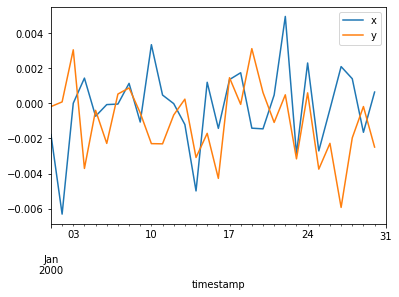

In [15]:
df[['x', 'y']].resample('24h').mean().compute().plot()

In [16]:
df[['x', 'y']].rolling(window='24h').mean().head()

,x,y
timestamp,,
2000-01-01 00:00:00,0.39,0.82
2000-01-01 00:00:01,0.04,0.35
2000-01-01 00:00:02,-0.09,0.55
2000-01-01 00:00:03,0.15,0.37
2000-01-01 00:00:04,-0.05,0.19


In [17]:
df.loc['2000-01-05']

,id,name,x,y
npartitions=1,,,,
2000-01-05 00:00:00.000000000,int64,object,float64,float64
2000-01-05 23:59:59.999999999,...,...,...,...


In [18]:
%time df.loc['2000-01-05'].compute()

CPU times: user 13.9 ms, sys: 15.5 ms, total: 29.4 ms
Wall time: 50.4 ms


,id,name,x,y
timestamp,,,,
2000-01-05 00:00:00,990,Tim,0.67,-0.19
2000-01-05 00:00:01,1022,Quinn,0.26,-0.20
2000-01-05 00:00:02,1007,Quinn,0.40,-0.18
2000-01-05 00:00:03,1012,Ray,-0.64,-0.43
2000-01-05 00:00:04,1007,Sarah,0.83,-0.31
...,...,...,...,...
2000-01-05 23:59:55,937,George,0.12,-0.75
2000-01-05 23:59:56,977,Victor,0.05,0.32
2000-01-05 23:59:57,959,Alice,-0.40,-0.43


## Set Index

Data is sorted by the index column.  This allows for faster access, joins, groupby-apply operations, etc..  However sorting data can be costly to do in parallel, so setting the index is both important to do, but only infrequently.

In [19]:
df = df.set_index('name')
df

,id,x,y
npartitions=30,,,
Alice,int64,float64,float64
Alice,...,...,...
...,...,...,...
Zelda,...,...,...
Zelda,...,...,...


Because computing this dataset is expensive and we can fit it in our available RAM, we persist the dataset to memory.

In [20]:
df = df.persist()

Dask now knows where all data lives, indexed cleanly by name.  As a result oerations like random access are cheap and efficient

In [21]:
%time df.loc['Alice'].compute()

CPU times: user 12.9 ms, sys: 12.3 ms, total: 25.2 ms
Wall time: 58.2 ms


,id,x,y
name,,,
Alice,1012,0.85,-0.09
Alice,1018,0.11,0.72
Alice,1006,-0.11,0.09
Alice,1008,-0.24,0.74
Alice,997,0.97,-0.35
...,...,...,...
Alice,976,-0.35,-0.36
Alice,1007,-0.23,-0.69
Alice,1016,-0.59,0.28


## Groupby Apply with Scikit-Learn

Now that our data is sorted by name we can easily do operations like random access on name, or groupby-apply with custom functions.

Here we train a different Scikit-Learn linear regression model on each name.

In [22]:
from sklearn.linear_model import LinearRegression

def train(partition):
    est = LinearRegression()
    est.fit(partition[['x']].values, partition.y.values)
    return est

In [23]:
df.groupby('name').apply(train, meta=object).compute()

/opt/conda/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator LinearRegression from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


name
Alice      LinearRegression()
Bob        LinearRegression()
Charlie    LinearRegression()
Dan        LinearRegression()
Edith      LinearRegression()
                  ...        
Victor     LinearRegression()
Wendy      LinearRegression()
Xavier     LinearRegression()
Yvonne     LinearRegression()
Zelda      LinearRegression()
Length: 26, dtype: object

## Further Reading

For a more in-depth introduction to Dask dataframes, see the [dask tutorial](https://github.com/dask/dask-tutorial), notebooks 04 and 07.